In [1]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from skimage.measure import regionprops
from napari_czifile2 import napari_get_reader
from skimage import io
import os 
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

In [2]:
def plot_2_channels(results, c1, c2, c1_name, c2_name, c1_color, c2_color, coordinates, 
                    image, metadata, all_rois, cell_borders, input, file, 
                    pixel_bounds=100, bbox_expansion=7, 
                    dapi_max=255, c1_max=255, c2_max=255): 
    
    # Remove -T from column names
    results.columns = results.columns.str.split('-T').str[0]

    # Make figure directory
    figure_dir = f'../figures/model_B_only_OSNs/{input}/{file.replace(".czi", "")}-{c1_name}-{c2_name}'
    if not os.path.exists(figure_dir):
        os.makedirs(figure_dir)

    # Clear directory
    for f in os.listdir(figure_dir):
        os.remove(os.path.join(figure_dir, f))

    # Scatter Plot 
    f, ax = plt.subplots(1, 1, figsize=(2, 2), dpi = 400) 
    sns.scatterplot(data=results, x=c1, y=c2, s=10, ax=ax, color='black', alpha=0.3, lw=0)

    # Plot coordinates using the data from the image 
    results_image = results[results['image'] == file].reset_index(drop=True)
    random_colors = sns.color_palette('colorblind', len(coordinates))
    cells = [] 
    for i, coord in enumerate(coordinates): 
        cell_idx = np.argmin(np.linalg.norm(results_image[[c1, c2]].values - coord, axis=1))
        cell = results_image.iloc[cell_idx].copy()  
        sns.scatterplot(data=pd.DataFrame([cell]), x=c1, y=c2, color=random_colors[i], s=30, ax=ax, lw=0, alpha=1)
        cell["color"] = random_colors[i] 
        cell["number"] = i + 1
        cells.append(cell)
    cells = pd.DataFrame(cells)

    # Plotting 
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlabel(f"Normalized {c1_name} Intensity", fontsize=6) 
    ax.set_ylabel(f"Normalized {c2_name} Intensity", fontsize=6)
    ax.tick_params(axis='both', which='major', labelsize=6)

    plt.tight_layout()
    plt.savefig(f"{figure_dir}/{file.replace('.czi', '')}-{c1_name}-{c2_name}-scatter.png", format="png", pad_inches=0, bbox_inches=0, transparent=False)
    plt.show()

    # Get scale for scale bar 
    x_scale_5 = 5 / metadata['scale'][2] # 5 um in pixels 

    def set_min_max(channel, min_val, max_val):
        if min_val == max_val:
            return np.zeros_like(channel)  # If min == max, return all zeros
        clipped = np.clip(channel, min_val, max_val)
        rescaled = (clipped - min_val) / (max_val - min_val) * 255
        return np.clip(rescaled, 0, 255)  # Ensure the values remain in the [0, 255] range

    # Remove -border from c1 and c2 names
    c1 = c1.split('-')[0]
    c2 = c2.split('-')[0]

    channels = [(i, metadata['name'][i]) for i in range(len(metadata['name']))]
    channels = [(i, channel) for i, channel in channels if any([name in channel for name in ["DAPI", c1, c2]])]

    for i, cell in cells.iterrows():
        # Retrieve image and z slice 
        x_bounds = int(cell['centroid_x']) - pixel_bounds, int(cell['centroid_x']) + pixel_bounds 
        y_bounds = int(cell['centroid_y']) - pixel_bounds, int(cell['centroid_y']) + pixel_bounds 
        cell_image = image[0, cell['z'], :, y_bounds[0]:y_bounds[1], x_bounds[0]:x_bounds[1]]  # shape: (channels, H, W)

        # Create composite RGB image
        rgb_image = np.zeros((cell_image.shape[1], cell_image.shape[2], 3), dtype=float)  # (H, W, 3)

        # -- DAPI (Grey): add to all channels
        dapi = [idx for idx, channel in channels if 'DAPI' in channel][0]
        dapi_adjusted = set_min_max(cell_image[dapi], 0, dapi_max)
        rgb_image[..., 0] += dapi_adjusted  # Red
        rgb_image[..., 1] += dapi_adjusted  # Green
        rgb_image[..., 2] += dapi_adjusted  # Blue

        # C1 
        c1_index = [idx for idx, channel in channels if c1 in channel][0]
        c1_adjusted = set_min_max(cell_image[c1_index], 0, c1_max) 
        if c1_color == "magenta": 
            rgb_image[..., 0] += c1_adjusted  
            rgb_image[..., 2] += c1_adjusted  
        elif c1_color == "cyan": 
            rgb_image[..., 1] += c1_adjusted
            rgb_image[..., 2] += c1_adjusted
        elif c1_color == "yellow": 
            rgb_image[..., 0] += c1_adjusted
            rgb_image[..., 1] += c1_adjusted

        # -- Cyan (c2): add to green and blue
        c2_index = [idx for idx, channel in channels if c2 in channel][0]
        c2_adjusted = set_min_max(cell_image[c2_index], 0, c2_max)
        if c2_color == "magenta": 
            rgb_image[..., 0] += c2_adjusted  
            rgb_image[..., 2] += c2_adjusted  
        elif c2_color == "cyan": 
            rgb_image[..., 1] += c2_adjusted
            rgb_image[..., 2] += c2_adjusted
        elif c2_color == "yellow": 
            rgb_image[..., 0] += c2_adjusted
            rgb_image[..., 1] += c2_adjusted

        # Normalize composite image to [0,1]
        rgb_image = np.clip(rgb_image/255, 0, 1)

        # Load ROIs and compute bbox (adjusted relative to the cell image)
        regions = regionprops(all_rois[cell['z'], :, :])
        region_labels = [region.label for region in regions]
        region = regions[region_labels.index(cell['z_id'])]
        bbox = region.bbox
        # Expand bbox by bbox_expansion pixels     
        bbox = (bbox[0] - bbox_expansion, bbox[1] - bbox_expansion, 
                bbox[2] + bbox_expansion, bbox[3] + bbox_expansion)
        # Adjust bbox to cell_image coordinates
        bbox = (bbox[0] - y_bounds[0], bbox[1] - x_bounds[0],
                bbox[2] - y_bounds[0], bbox[3] - x_bounds[0])
        # For clarity, unpack bbox (top, left, bottom, right)
        y1, x1, y2, x2 = bbox

        # Create figure with gridspec: main image in left column (spanning all rows) 
        # and three zoom panels in the right column (each taking 1/3 height)
        # Adjust fig size and width ratios as needed.
        fig_width = 1   # total width (main image + zoom panels)
        fig_height = 0.75  # height of the main image (zoom panels share this height)
        f = plt.figure(figsize=(fig_width, fig_height), dpi=400)
        gs = gridspec.GridSpec(nrows=3, ncols=2, width_ratios=[4, 1])
        ax_main = f.add_subplot(gs[:, 0])
        ax_zoom_gray = f.add_subplot(gs[0, 1])
        ax_zoom_magenta = f.add_subplot(gs[1, 1])
        ax_zoom_cyan = f.add_subplot(gs[2, 1])

        # Plot main composite image
        ax_main.imshow(rgb_image)
        ax_main.axis("off")
        # Add border to main image
        ax_main.add_patch(plt.Rectangle((0, 0), cell_image.shape[2]-1, cell_image.shape[1]-1, fill=False, edgecolor=cell['color'], lw=2))
        # Add text legends on main image
        ax_main.text(5, 25, "DAPI", color='white', fontsize=6, weight='bold')
        ax_main.text(5, 45, c1_name, color=c1_color, fontsize=6, weight='bold')
        ax_main.text(5, 65, c2_name, color=c2_color, fontsize=6, weight='bold')
        # Add scale bar on main image
        ax_main.plot([2*pixel_bounds-20-x_scale_5, 2*pixel_bounds-20], 
                    [2*pixel_bounds-20, 2*pixel_bounds-20], color='white', lw=1)
        
        ax_main.add_patch(plt.Rectangle((x1, y1), x2-x1, y2-y1, fill=False, edgecolor='white', lw=1))

        # ----- Create zoom panels -----
        # Zoom for Grey (DAPI)
        zoom_dapi = dapi_adjusted[y1:y2, x1:x2]
        # Build RGB image: all channels get the DAPI intensity
        dapi_zoom = np.zeros((zoom_dapi.shape[0], zoom_dapi.shape[1], 3), dtype=float)
        dapi_zoom[..., 0] = zoom_dapi
        dapi_zoom[..., 1] = zoom_dapi
        dapi_zoom[..., 2] = zoom_dapi
        dapi_zoom = np.clip(dapi_zoom/255, 0, 1)
        ax_zoom_gray.imshow(dapi_zoom)
        ax_zoom_gray.axis("off")
        ax_zoom_gray.add_patch(plt.Rectangle((0, 0), zoom_dapi.shape[1]-1, zoom_dapi.shape[0]-1, fill=False, edgecolor='grey', lw=1))
        
        # Plot cell border on zoom panel in red 
        # Get cell border 
        cell_border = cell_borders[cell['z'], :, :] == cell['z_id']
        cell_border = cell_border[y_bounds[0]:y_bounds[1], x_bounds[0]:x_bounds[1]]
        cell_border = cell_border[y1:y2, x1:x2]
        # Make background transparent and set cell border pixels to red 
        cell_border_rgba = np.zeros((cell_border.shape[0], cell_border.shape[1], 4), dtype=float)
        cell_border_rgba[cell_border, 0] = 1 # Red channel
        cell_border_rgba[cell_border, 3] = 0.5 # Alpha channel
        # Plot RGBA image on top of the same zoom panel
        ax_zoom_gray.imshow(cell_border_rgba, alpha=1)

        # Zoom for Magenta (c1)
        zoom_c1 = c1_adjusted[y1:y2, x1:x2]
        # Build an RGB image: red and blue channels from c1
        zoom_c1_rgb = np.zeros((zoom_c1.shape[0], zoom_c1.shape[1], 3), dtype=float)
        if c1_color == "magenta": 
            zoom_c1_rgb[..., 0] += zoom_c1  
            zoom_c1_rgb[..., 2] += zoom_c1  
        elif c1_color == "cyan": 
            zoom_c1_rgb[..., 1] += zoom_c1
            zoom_c1_rgb[..., 2] += zoom_c1
        elif c1_color == "yellow": 
            zoom_c1_rgb[..., 0] += zoom_c1
            zoom_c1_rgb[..., 1] += zoom_c1
        zoom_c1_rgb = np.clip(zoom_c1_rgb/255, 0, 1)
        ax_zoom_magenta.imshow(zoom_c1_rgb)
        ax_zoom_magenta.axis("off")
        ax_zoom_magenta.add_patch(plt.Rectangle((0, 0), zoom_c1.shape[1]-1, zoom_c1.shape[0]-1, fill=False, edgecolor=c1_color, lw=1))
        ax_zoom_magenta.imshow(cell_border_rgba, alpha=0.5)

        # Zoom for Cyan (c2)
        zoom_c2 = c2_adjusted[y1:y2, x1:x2]
        # Build an RGB image: green and blue channels from c2
        zoom_c2_rgb = np.zeros((zoom_c2.shape[0], zoom_c2.shape[1], 3), dtype=float)
        if c2_color == "magenta": 
            zoom_c2_rgb[..., 0] += zoom_c2  
            zoom_c2_rgb[..., 2] += zoom_c2  
        elif c2_color == "cyan": 
            zoom_c2_rgb[..., 1] += zoom_c2
            zoom_c2_rgb[..., 2] += zoom_c2
        elif c2_color == "yellow": 
            zoom_c2_rgb[..., 0] += zoom_c2
            zoom_c2_rgb[..., 1] += zoom_c2
        zoom_c2_rgb = np.clip(zoom_c2_rgb/255, 0, 1)
        ax_zoom_cyan.imshow(zoom_c2_rgb)
        ax_zoom_cyan.axis("off")
        ax_zoom_cyan.add_patch(plt.Rectangle((0, 0), zoom_c2.shape[1]-1, zoom_c2.shape[0]-1, fill=False, edgecolor=c2_color, lw=1))
        ax_zoom_cyan.imshow(cell_border_rgba, alpha=0.5)

        plt.tight_layout(pad=0)
        #plt.savefig(f"{figure_dir}/{file.replace('.czi', '')}-{c1_name}-{c2_name}-cell_{cell["number"]}.png", format="png", pad_inches=0, bbox_inches='tight', transparent=False)
        plt.show()

In [3]:
def plot_thresholds(results, nuc_thresholds, cyto_thresholds, 
                    channels, channel_names, channel_colors, channel_maxs,
                    image, metadata, all_rois, cell_borders, file_name, 
                    pixel_bounds=100, bbox_expansion=7, 
                    dapi_max=255): 
    

    # Plot coordinates using the data from the image 
    results_image = results[results['image'] == file_name].reset_index(drop=True)
    cells = [] 
    for i, channel in enumerate(channels):
        # Choose nuclear cell 
        nuc_threshold = nuc_thresholds[i]
        cell_idx = np.argmin(np.abs(results_image[(channel+"-nucleus-sum")].values - nuc_threshold))
        cell = results_image.iloc[cell_idx].copy()  
        cell['nuc_cyto'] = 'nuclear'
        cell['thresh'] = channel 
        cells.append(cell)

        # Choose cytoplasmic cell 
        cyto_threshold = cyto_thresholds[i] 
        cell_idx = np.argmin(np.abs(results_image[(channel+"-cyto-sum")].values - cyto_threshold))
        cell = results_image.iloc[cell_idx].copy()  
        cell['nuc_cyto'] = 'cytoplasmic'
        cell['thresh'] = channel
        cells.append(cell)
    cells = pd.DataFrame(cells)

    # Get scale for scale bar 
    x_scale_5 = 5 / metadata['scale'][2] # 5 um in pixels 

    def set_min_max(channel, min_val, max_val):
        if min_val == max_val:
            return np.zeros_like(channel)  # If min == max, return all zeros
        clipped = np.clip(channel, min_val, max_val)
        rescaled = (clipped - min_val) / (max_val - min_val) * 255
        return np.clip(rescaled, 0, 255)  # Ensure the values remain in the [0, 255] range

    image_channels = [(i, metadata['name'][i]) for i in range(len(metadata['name']))]

    for i, cell in cells.iterrows():
        # Retrieve image and z slice 
        x_bounds = int(cell['centroid_x']) - pixel_bounds, int(cell['centroid_x']) + pixel_bounds 
        y_bounds = int(cell['centroid_y']) - pixel_bounds, int(cell['centroid_y']) + pixel_bounds 
        cell_image = image[0, cell['z'], :, y_bounds[0]:y_bounds[1], x_bounds[0]:x_bounds[1]]  # shape: (channels, H, W)

        # Create composite RGB image
        rgb_image = np.zeros((cell_image.shape[1], cell_image.shape[2], 3), dtype=float)  # (H, W, 3)

        # -- DAPI (Grey): add to all channels
        dapi = [idx for idx, channel in image_channels if 'DAPI' in channel][0]
        dapi_adjusted = set_min_max(cell_image[dapi], 0, dapi_max)
        rgb_image[..., 0] += dapi_adjusted  # Red
        rgb_image[..., 1] += dapi_adjusted  # Green
        rgb_image[..., 2] += dapi_adjusted  # Blue

        # C1 
        for channel, color, cmax in zip(channels, channel_colors, channel_maxs):
            c_index = [idx for idx, channel_ in image_channels if channel in channel_][0]
            c_adjusted = set_min_max(cell_image[c_index], 0, cmax) 
            if color == "magenta": 
                rgb_image[..., 0] += c_adjusted  
                rgb_image[..., 2] += c_adjusted  
            elif color == "cyan": 
                rgb_image[..., 1] += c_adjusted
                rgb_image[..., 2] += c_adjusted
            elif color == "yellow": 
                rgb_image[..., 0] += c_adjusted
                rgb_image[..., 1] += c_adjusted

        # Normalize composite image to [0,1]
        rgb_image = np.clip(rgb_image/255, 0, 1)

        # Load ROIs and compute bbox (adjusted relative to the cell image)
        regions = regionprops(all_rois[cell['z'], :, :])
        region_labels = [region.label for region in regions]
        region = regions[region_labels.index(cell['z_id'])]
        bbox = region.bbox
        # Expand bbox by bbox_expansion pixels     
        bbox = (bbox[0] - bbox_expansion, bbox[1] - bbox_expansion, 
                bbox[2] + bbox_expansion, bbox[3] + bbox_expansion)
        # Adjust bbox to cell_image coordinates
        bbox = (bbox[0] - y_bounds[0], bbox[1] - x_bounds[0],
                bbox[2] - y_bounds[0], bbox[3] - x_bounds[0])
        # For clarity, unpack bbox (top, left, bottom, right)
        y1, x1, y2, x2 = bbox

        # Create figure with gridspec: main image in left column (spanning all rows) 
        # and three zoom panels in the right column (each taking 1/3 height)
        f = plt.figure(figsize=(1, 0.75), dpi=400)
        gs = gridspec.GridSpec(nrows=len(channels)+1, ncols=2, width_ratios=[4, 1])

        # Plot main composite image
        ax_main = f.add_subplot(gs[:, 0])
        ax_main.imshow(rgb_image)
        ax_main.axis("off")
        # Add text legends on main image
        ax_main.text(5, 25, "DAPI", color='white', fontsize=6, weight='bold')
        for i, channel_name, color in zip(range(len(channels)), channel_names, channel_colors):
            ax_main.text(5, 45+20*i, channel_name, color=color, fontsize=6, weight='bold')
        # Add scale bar on main image
        ax_main.plot([2*pixel_bounds-20-x_scale_5, 2*pixel_bounds-20], 
                    [2*pixel_bounds-20, 2*pixel_bounds-20], color='white', lw=1)
        
        # Add bbox to image 
        ax_main.add_patch(plt.Rectangle((x1, y1), x2-x1, y2-y1, fill=False, edgecolor='white', lw=1))

        # ----- Create zoom panels -----
        ax_zoom_gray = f.add_subplot(gs[0, 1])
        # Zoom for Grey (DAPI)
        zoom_dapi = dapi_adjusted[y1:y2, x1:x2]
        # Build RGB image: all channels get the DAPI intensity
        dapi_zoom = np.zeros((zoom_dapi.shape[0], zoom_dapi.shape[1], 3), dtype=float)
        dapi_zoom[..., 0] = zoom_dapi
        dapi_zoom[..., 1] = zoom_dapi
        dapi_zoom[..., 2] = zoom_dapi
        dapi_zoom = np.clip(dapi_zoom/255, 0, 1)
        ax_zoom_gray.imshow(dapi_zoom)
        ax_zoom_gray.axis("off")
        ax_zoom_gray.add_patch(plt.Rectangle((0, 0), zoom_dapi.shape[1]-1, zoom_dapi.shape[0]-1, fill=False, edgecolor='grey', lw=1))
        
        # Plot cell border on zoom panel in red 
        # Get cell border 
        cell_border = cell_borders[cell['z'], :, :] == cell['z_id']
        cell_border = cell_border[y_bounds[0]:y_bounds[1], x_bounds[0]:x_bounds[1]]
        cell_border = cell_border[y1:y2, x1:x2]
        # Make background transparent and set cell border pixels to red 
        cell_border_rgba = np.zeros((cell_border.shape[0], cell_border.shape[1], 4), dtype=float)
        cell_border_rgba[cell_border, 0] = 1 # Red channel
        cell_border_rgba[cell_border, 3] = 0.5 # Alpha channel
        # Plot RGBA image on top of the same zoom panel
        ax_zoom_gray.imshow(cell_border_rgba, alpha=1)

        # Zoom for other channels 
        for i, (channel, color, cmax) in enumerate(zip(channels, channel_colors, channel_maxs)):
            ax_c = f.add_subplot(gs[i+1, 1])
            c_index = [idx for idx, channel_ in image_channels if channel in channel_][0]
            c_adjusted = set_min_max(cell_image[c_index], 0, cmax) 
            zoom_c = c_adjusted[y1:y2, x1:x2]
            # Build an RGB image: red and blue channels from c1
            zoom_c_rgb = np.zeros((zoom_c.shape[0], zoom_c.shape[1], 3), dtype=float)
            if color == "magenta": 
                zoom_c_rgb[..., 0] += zoom_c  
                zoom_c_rgb[..., 2] += zoom_c  
            elif color == "cyan": 
                zoom_c_rgb[..., 1] += zoom_c
                zoom_c_rgb[..., 2] += zoom_c
            elif color == "yellow": 
                zoom_c_rgb[..., 0] += zoom_c
                zoom_c_rgb[..., 1] += zoom_c
            zoom_c_rgb = np.clip(zoom_c_rgb/255, 0, 1)
            ax_c.imshow(zoom_c_rgb)
            ax_c.axis("off")
            # Add border to zoom image only if this channel is the threshold 
            if cell['thresh'] == channel:
                ax_c.add_patch(plt.Rectangle((0, 0), zoom_c.shape[1]-1, zoom_c.shape[0]-1, fill=False, edgecolor=color, lw=1))
            if cell['nuc_cyto'] == 'cytoplasmic':
                ax_c.imshow(cell_border_rgba, alpha=0.5)

        plt.tight_layout(pad=0)
        #plt.savefig(f"{figure_dir}/{file.replace('.czi', '')}-{c1_name}-{c2_name}-cell_{cell["number"]}.png", format="png", pad_inches=0, bbox_inches='tight', transparent=False)
        plt.show()

In [4]:
raw_data_dirs = os.listdir('../raw-data/')
# Get directories that contains 488, 546 or 647 
raw_data_dirs = [x for x in raw_data_dirs if '488' in x or '546' in x or '647' in x]
raw_data_dirs

['20250307 B1 P14 U34-B3-546 Chymotrypsin-B2-647 DAPI',
 '20250328 1 P14 T79-intergenic-b2-647 T79-exonic-b1-546 DAPI',
 '20250325 6 9e198-b3-488 9e197-b1-546 9e196-b2-647 dapi',
 '20250328 5 P14 LOC603-b3-488 9E108-b1-546 9E116-b2-647 DAPI',
 '20250325 5 p14 g1-b1-546 lnc7-b2-647 dapi',
 '20250328 2 P14 R2-b3-488 Q1-b1-546 Lnc6-b2-647 DAPI',
 '20250328 4 P14 9E129-b3-488 LOC104-b1-546 9E116-b2-647 dapi',
 '20250325 4 p14 u34-b3-488 lnc4-b1-546 u21-b5-647 dapi',
 '20250328 3 P14 Lnc3-b3-488 L16-b2-594 Lnc2-b5-647 DAPI']

## Figure 1 

In [ ]:
input = 'u21'
input = [d for d in raw_data_dirs if input in d][0]
print(f'Using {input} as input directory')
# Load the results 
results_dir = f'../results/{input}'
results_path = os.path.join(results_dir, 'all_results_nuclei_cytoplasm_markers.csv')
results = pd.read_csv(results_path)

Using 20250325 4 p14 u34-b3-488 lnc4-b1-546 u21-b5-647 dapi as input directory


In [77]:
results = results[results['border_pxls'] > 200]

In [78]:
channels = ['AF488', 'AF546', 'AF647']
channel_names = ["U34", "PR", "U21"]
channel_colors = ["yellow", "magenta", "cyan"]
cyto_thresholds = [0.4, 0.3, 0.35]
nuc_thresholds =  [0.25, 0.2, 0.2]
channel_maxs = [255, 255, 255]

In [178]:
# Calculate the percentage of the total signal intensity thats cytoplasmic vs nuclear 
for channel in channels: 
    results[f'{channel}-cyto-prop'] = results[f'{channel}-cyto-sum'] #/ (results[f'{channel}-nucleus-sum'] + results[f'{channel}-cyto-sum'])
    results[f'{channel}-total-sum'] = results[f'{channel}-cyto-sum'] + results[f'{channel}-nucleus-sum']
    
# Get only the cytoplasmic results
results_cytoplasmic = results[results['cytoplasmic'].notnull()]


# Melt results_thresholded, grouping by image and cytoplasmic, for cytoplasm
results_melted_cyto = results_cytoplasmic.melt(id_vars=['image', 'z', 'z_id', 'cytoplasmic'],
                                               value_vars=[c+"-cyto-prop" for c in channels],
                                               var_name='channel', 
                                               value_name='cyto-prop')
results_melted_cyto['channel'] = results_melted_cyto['channel'].str.replace('-cyto-prop', '')


# Melt results_thresholded, grouping by image and cytoplasmic, for nucleus
results_melted_nucleus = results_cytoplasmic.melt(id_vars=['image', 'z', 'z_id', 'cytoplasmic'],
                                               value_vars=[c+"-total-sum" for c in channels],
                                               var_name='channel', 
                                               value_name='total-sum')
results_melted_nucleus['channel'] = results_melted_nucleus['channel'].str.replace('-total-sum', '')

# Combine the two melted dataframes
results_melted = pd.merge(results_melted_cyto, results_melted_nucleus, on=['image', 'z', 'z_id', 'cytoplasmic', 'channel'])
results_melted['channel_name'] = results_melted['channel'].map(dict(zip(channels, channel_names)))
results_melted['cytoplasmic_name'] = results_melted['cytoplasmic'].map(dict(zip(channels, channel_names)))
results_melted['cytoplasmic_name'] = results_melted['cytoplasmic_name'] + " cytoplasmic"
results_melted

image   z  z_id cytoplasmic channel  \
0    20250325 4 t19 lncrna sample 1 great.czi   4    43       AF647   AF488   
1    20250325 4 t19 lncrna sample 1 great.czi  10    86       AF647   AF488   
2    20250325 4 t19 lncrna sample 1 great.czi  13   159       AF488   AF488   
3    20250325 4 t19 lncrna sample 1 great.czi  13   223       AF488   AF488   
4    20250325 4 t19 lncrna sample 1 great.czi  13   268       AF488   AF488   
..                                        ...  ..   ...         ...     ...   
298  20250325 4 t19 lncrna sample 4 great.czi  65    93       AF647   AF647   
299  20250325 4 t19 lncrna sample 4 great.czi  65   318       AF647   AF647   
300  20250325 4 t19 lncrna sample 4 great.czi  66    75       AF647   AF647   
301  20250325 4 t19 lncrna sample 4 great.czi  72   162       AF488   AF647   
302  20250325 4 t19 lncrna sample 4 great.czi  75    61       AF647   AF647   

     cyto-prop  total-sum channel_name cytoplasmic_name  
0         2236      18826          U34  U21 cytoplasmic  
1         1840      13216          U34  U21 cytoplasmic  
2         9411      48713          U34  U34 cytoplasmic  
3         7803      48689          U34  U34 cytoplasmic  
4         6344      36412          U34  U34 cytoplasmic  
..         ...        ...          ...              ...  
298      11519      70318          U21  U21 cytoplasmic  
299       5441      63871          U21  U21 cytoplasmic  
300       5339      63650          U21  U21 cytoplasmic  
301       1006       5101          U21  U34 cytoplasmic  
302       9145      87596          U21  U21 cytoplasmic  

[303 rows x 9 columns]

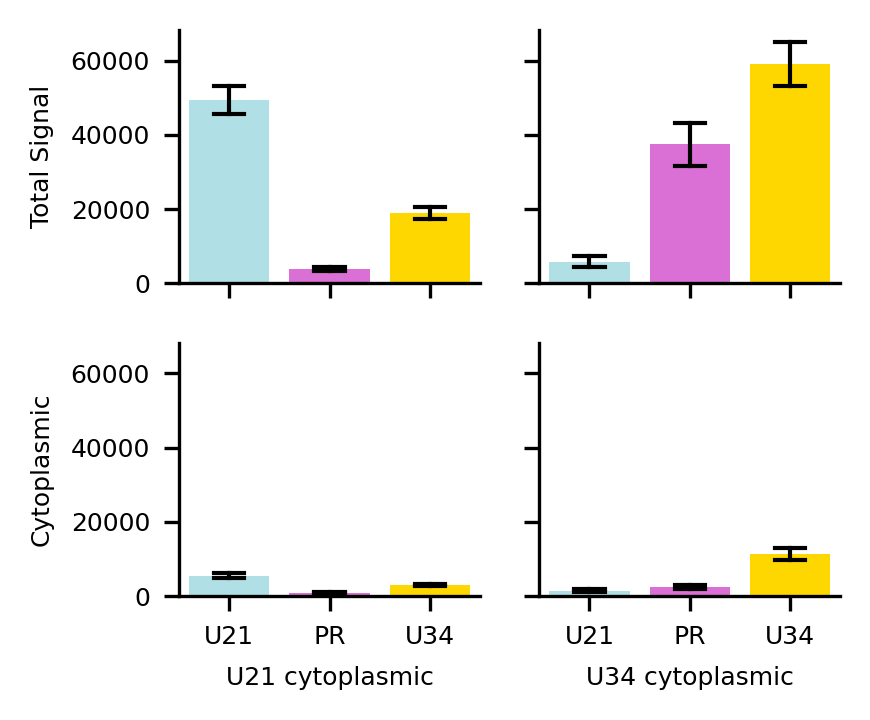

In [179]:
cytoplasmic_channels = ["U21 cytoplasmic", "U34 cytoplasmic"]
f, axs = plt.subplots(2, 2, figsize=(3, 2.5), dpi = 300, sharex=True, sharey=True)
for i, cytoplasmic_channel in enumerate(cytoplasmic_channels):
    results_channel = results_melted[results_melted["cytoplasmic_name"] == cytoplasmic_channel]
    ax = axs[0, i]
    sns.barplot(data=results_channel, x="channel_name", y="total-sum", ax=ax, palette=['powderblue', 'orchid', 'gold'], order=["U21", "PR", "U34"], saturation=1, 
                alpha=1, lw=0, errorbar=("ci", 95), capsize=0.3, errwidth=1, errcolor='black')
    #sns.swarmplot(data=results_channel, x="channel_name", y="total-sum", ax=ax, color='black', alpha=0.5, s=2, legend=False, dodge=True)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlabel(f"{cytoplasmic_channel}", fontsize=6)
    ax.set_ylabel("Total Signal", fontsize=6)
    ax.tick_params(axis='both', which='major', labelsize=6)

    ax = axs[1, i]
    sns.barplot(data=results_channel, x="channel_name", y="cyto-prop", ax=ax, palette=['powderblue', 'orchid', 'gold'], order=["U21", "PR", "U34"], saturation=1, 
                alpha=1, lw=0, errorbar=("ci", 95), capsize=0.3, errwidth=1, errcolor='black')
    #sns.swarmplot(data=results_channel, x="channel_name", y="cyto-sum", ax=ax, color='black', alpha=0.5, s=2, legend=False, dodge=True)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlabel(f"{cytoplasmic_channel}", fontsize=6)
    ax.set_ylabel("Cytoplasmic", fontsize=6)
    ax.tick_params(axis='both', which='major', labelsize=6)

plt.tight_layout()

In [81]:
"""quantile = 0.0001 
channels_to_normalize = [c + "-nucleus-sum" for c in channels] + [c + "-cyto-sum" for c in channels]
for sample in results['image'].unique():
        results_sample = results[results['image'] == sample]
        for channel in channels_to_normalize: 
            lower = results_sample[channel].quantile(quantile)
            upper = results_sample[channel].quantile(1-quantile)
            results_sample[channel] = (results_sample[channel] - lower) / (upper - lower)
        results.loc[results['image'] == sample] = results_sample"""

'quantile = 0.0001 \nchannels_to_normalize = [c + "-nucleus-sum" for c in channels] + [c + "-cyto-sum" for c in channels]\nfor sample in results[\'image\'].unique():\n        results_sample = results[results[\'image\'] == sample]\n        for channel in channels_to_normalize: \n            lower = results_sample[channel].quantile(quantile)\n            upper = results_sample[channel].quantile(1-quantile)\n            results_sample[channel] = (results_sample[channel] - lower) / (upper - lower)\n        results.loc[results[\'image\'] == sample] = results_sample'

In [5]:
file_number = 0 
results_files = os.listdir(f'../raw-data/{input}')
image = results_files[file_number].replace(".csv", ".czi")
image_path = f'../raw-data/{input}/{image}'
reader = napari_get_reader(image_path)
if reader is not None:
    layer_data = reader(image_path)
    image_data, metadata, layer_type = layer_data[0]
    print(f"Loaded {image_path}")
    print("Metadata:", metadata)
    print("Image shape:", image_data.shape)  

# Load ROIs 
all_rois_path = f'../results/{input}/{image.replace(".czi", "_rois.npy")}'
all_rois = np.load(all_rois_path)
print(f"Loaded {all_rois_path}")

# Load cell_borders 
cell_borders_path = f'../results/{input}/{image.replace(".czi", "_cell_borders.npy")}'
cell_borders = np.load(cell_borders_path)
print(f"Loaded {cell_borders_path}")

FileNotFoundError: [Errno 2] No such file or directory: '../raw-data/<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x7db7c1852b40>>'

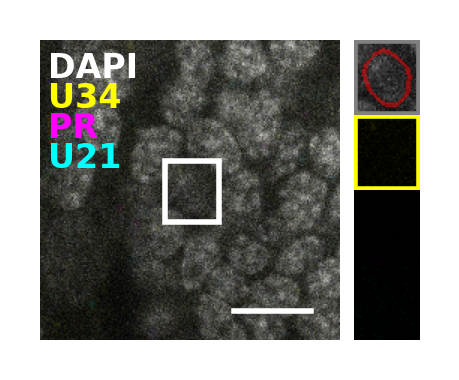

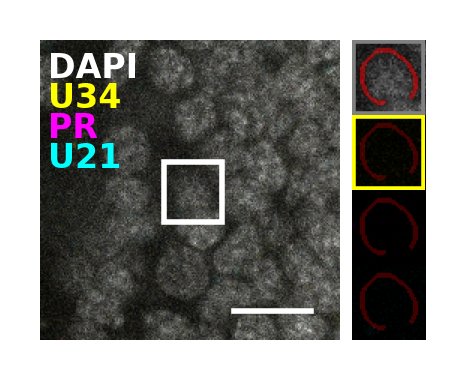

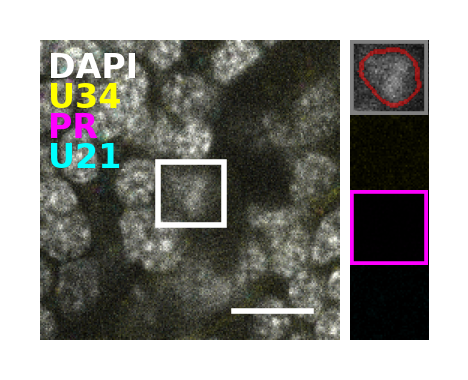

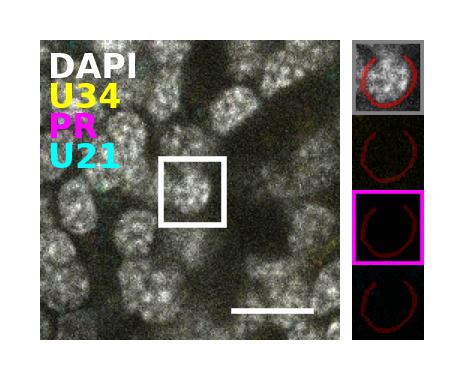

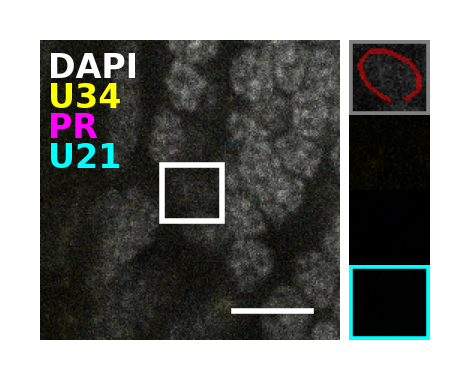

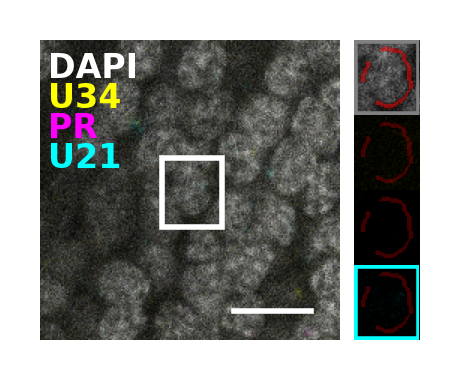

In [83]:
plot_thresholds(results, nuc_thresholds, cyto_thresholds,
                channels, channel_names, channel_colors, channel_maxs, 
                image_data, metadata, all_rois, cell_borders, image, 
                pixel_bounds=100, bbox_expansion=7) 

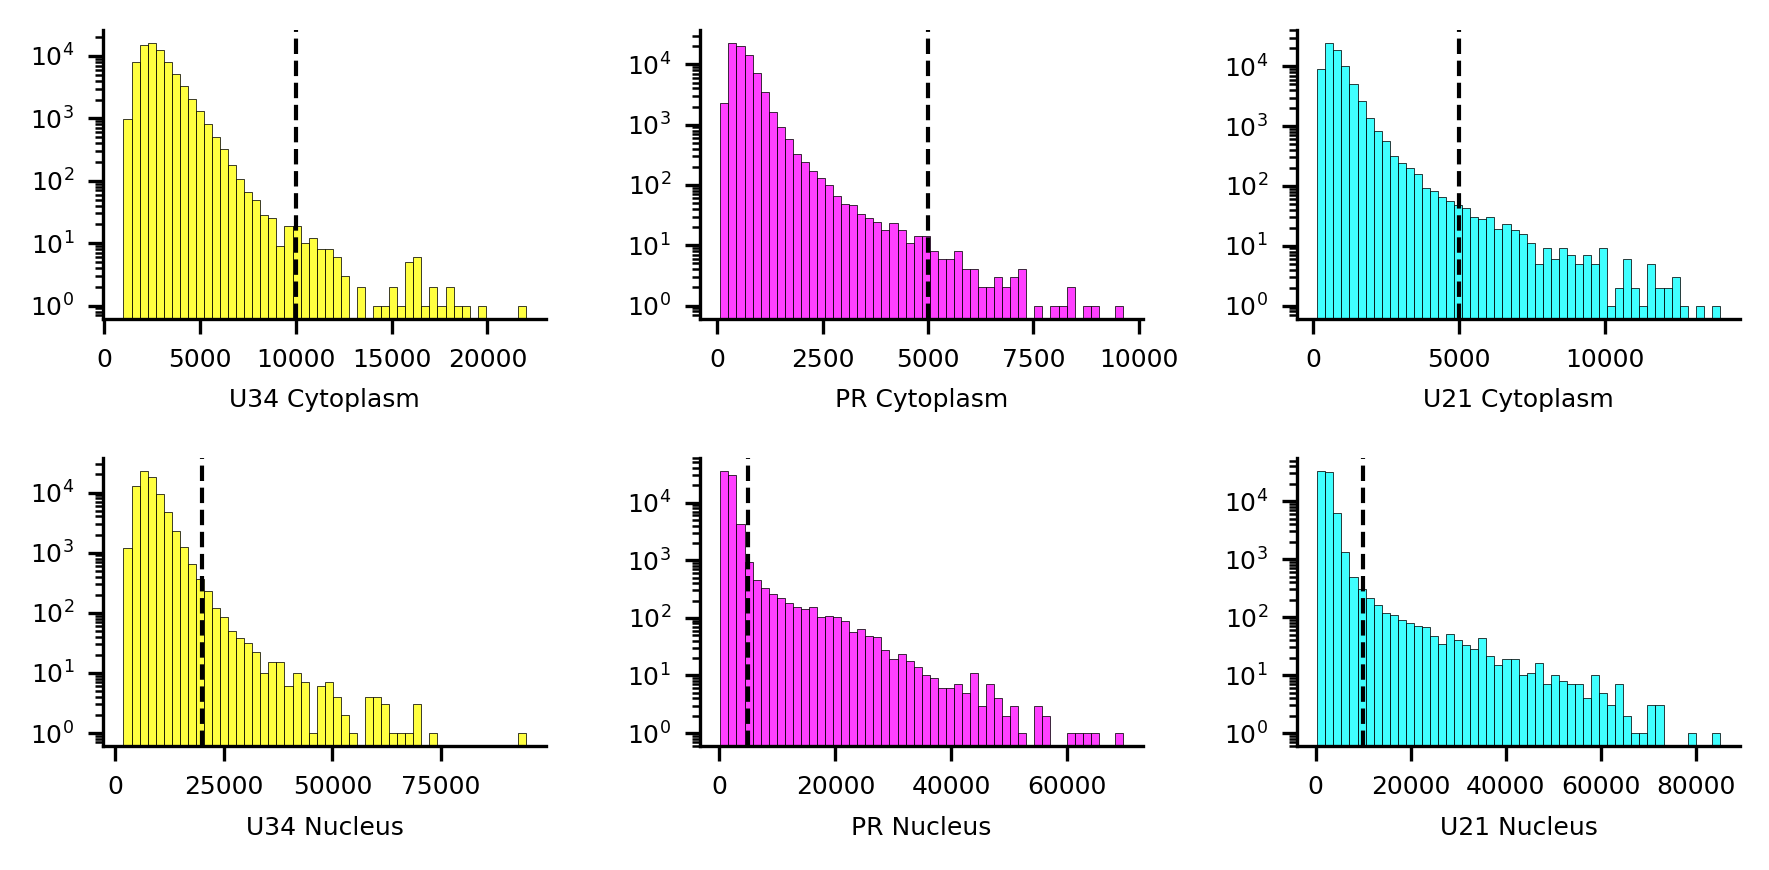

In [174]:
# Plot histograms of -cyto-sum and -nucleus-sum for all channels 
f, ax = plt.subplots(2, len(channels), figsize=(2*len(channels), 3), dpi=300)
for i, channel in enumerate(channels): 
    # Plot -cyto-sum
    sns.histplot(data=results, x=f'{channel}-cyto-sum', ax=ax[0][i], color=channel_colors[i], bins=50)
    ax[0][i].set_yscale('log')
    ax[0][i].set_xlabel(f'{channel_names[i]} Cytoplasm', fontsize=6)
    ax[0][i].tick_params(axis='both', which='major', labelsize=6)
    ax[0][i].set_ylabel('')
    ax[0][i].spines['top'].set_visible(False)
    ax[0][i].spines['right'].set_visible(False)
    ax[0][i].axvline(cyto_thresholds[i], color='black', linestyle='--', lw=1)

    # Plot -nucleus-sum
    sns.histplot(data=results, x=f'{channel}-nucleus-sum', ax=ax[1][i], color=channel_colors[i], bins=50)
    ax[1][i].set_yscale('log')
    ax[1][i].set_xlabel(f'{channel_names[i]} Nucleus', fontsize=6)
    ax[1][i].tick_params(axis='both', which='major', labelsize=6)
    ax[1][i].set_ylabel('')
    ax[1][i].spines['top'].set_visible(False)
    ax[1][i].spines['right'].set_visible(False)
    ax[1][i].axvline(nuc_thresholds[i], color='black', linestyle='--', lw=1)

plt.tight_layout()
plt.show()

In [145]:
channels = ['AF488', 'AF546', 'AF647']
channel_names = ["U34", "PR", "U21"]
channel_colors = ["yellow", "magenta", "cyan"]
cyto_thresholds = [5000, 5000, 4000]
nuc_thresholds =  [5000, 5000, 10_000]
channel_maxs = [255, 255, 255]

In [146]:
# Calculate proportions of cells above the thresholds
results_thresholded = results.groupby(['image', 'cytoplasmic']).size().reset_index(name='num_cells')
for i, row in results_thresholded.iterrows():
    results_subset = results[(results['image'] == row['image']) & (results['cytoplasmic'] == row['cytoplasmic'])]
    for j, channel in enumerate(channels):
        results_thresholded.at[i, f'{channel}-cyto'] = sum(results_subset[f'{channel}-cyto-sum'] > cyto_thresholds[j]) #/ row['num_cells']
        results_thresholded.at[i, f'{channel}-nucleus'] = sum(results_subset[f'{channel}-nucleus-sum'] > nuc_thresholds[j]) #/ row['num_cells']

# Melt results_thresholded, grouping by image and cytoplasmic, for cytoplasm
results_melted_cyto = results_thresholded.melt(id_vars=['image', 'cytoplasmic'],
                                               value_vars=[c+"-cyto" for c in channels],
                                               var_name='channel', 
                                               value_name='cyto_count')
results_melted_cyto['channel'] = results_melted_cyto['channel'].str.replace('-cyto', '')

# Melt results_thresholded, grouping by image and cytoplasmic, for nucleus
results_melted_nucleus = results_thresholded.melt(id_vars=['image', 'cytoplasmic'],
                                               value_vars=[c+"-nucleus" for c in channels],
                                               var_name='channel', 
                                               value_name='nucleus_count')
results_melted_nucleus['channel'] = results_melted_nucleus['channel'].str.replace('-nucleus', '')

# Combine the two melted dataframes
results_melted = pd.merge(results_melted_cyto, results_melted_nucleus, on=['image', 'cytoplasmic', 'channel'])
results_melted['channel_name'] = results_melted['channel'].map(dict(zip(channels, channel_names)))
results_melted['cytoplasmic_name'] = results_melted['cytoplasmic'].map(dict(zip(channels, channel_names)))
results_melted['cytoplasmic_name'] = results_melted['cytoplasmic_name'] + " cytoplasmic"
results_melted.head()

image cytoplasmic channel  cyto_count  \
0  20250325 4 t19 lncrna sample 1 great.czi       AF488   AF488        11.0   
1  20250325 4 t19 lncrna sample 1 great.czi       AF647   AF488         0.0   
2  20250325 4 t19 lncrna sample 2 great.czi       AF488   AF488         4.0   
3  20250325 4 t19 lncrna sample 2 great.czi       AF647   AF488         0.0   
4  20250325 4 t19 lncrna sample 3 great.czi       AF488   AF488         9.0   

   nucleus_count channel_name cytoplasmic_name  
0           11.0          U34  U34 cytoplasmic  
1           23.0          U34  U21 cytoplasmic  
2            6.0          U34  U34 cytoplasmic  
3           19.0          U34  U21 cytoplasmic  
4            9.0          U34  U34 cytoplasmic

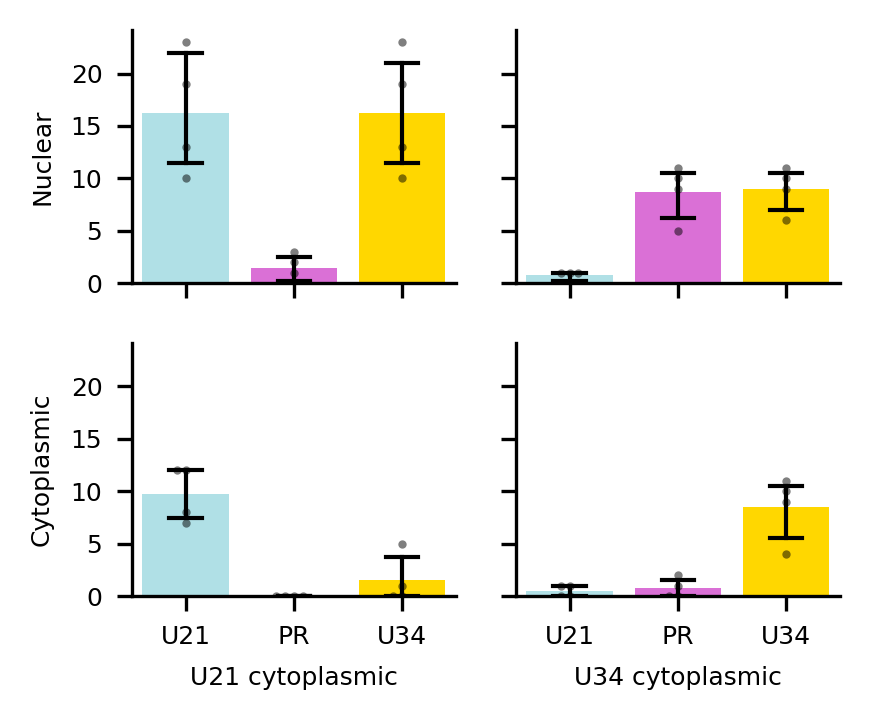

In [147]:
cytoplasmic_channels = ["U21 cytoplasmic", "U34 cytoplasmic"]
f, axs = plt.subplots(2, 2, figsize=(3, 2.5), dpi = 300, sharex=True, sharey=True)
for i, cytoplasmic_channel in enumerate(cytoplasmic_channels):
    results_channel = results_melted[results_melted["cytoplasmic_name"] == cytoplasmic_channel]
    ax = axs[0, i]
    sns.barplot(data=results_channel, x="channel_name", y="nucleus_count", ax=ax, palette=['powderblue', 'orchid', 'gold'], order=["U21", "PR", "U34"], saturation=1, 
                alpha=1, lw=0, errorbar=("ci", 95), capsize=0.3, errwidth=1, errcolor='black')
    sns.swarmplot(data=results_channel, x="channel_name", y="nucleus_count", ax=ax, color='black', alpha=0.5, s=2, legend=False, dodge=True)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlabel(f"{cytoplasmic_channel}", fontsize=6)
    ax.set_ylabel("Nuclear", fontsize=6)
    ax.tick_params(axis='both', which='major', labelsize=6)

    ax = axs[1, i]
    sns.barplot(data=results_channel, x="channel_name", y="cyto_count", ax=ax, palette=['powderblue', 'orchid', 'gold'], order=["U21", "PR", "U34"], saturation=1, 
                alpha=1, lw=0, errorbar=("ci", 95), capsize=0.3, errwidth=1, errcolor='black')
    sns.swarmplot(data=results_channel, x="channel_name", y="cyto_count", ax=ax, color='black', alpha=0.5, s=2, legend=False, dodge=True)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlabel(f"{cytoplasmic_channel}", fontsize=6)
    ax.set_ylabel("Cytoplasmic", fontsize=6)
    ax.tick_params(axis='both', which='major', labelsize=6)

plt.tight_layout()

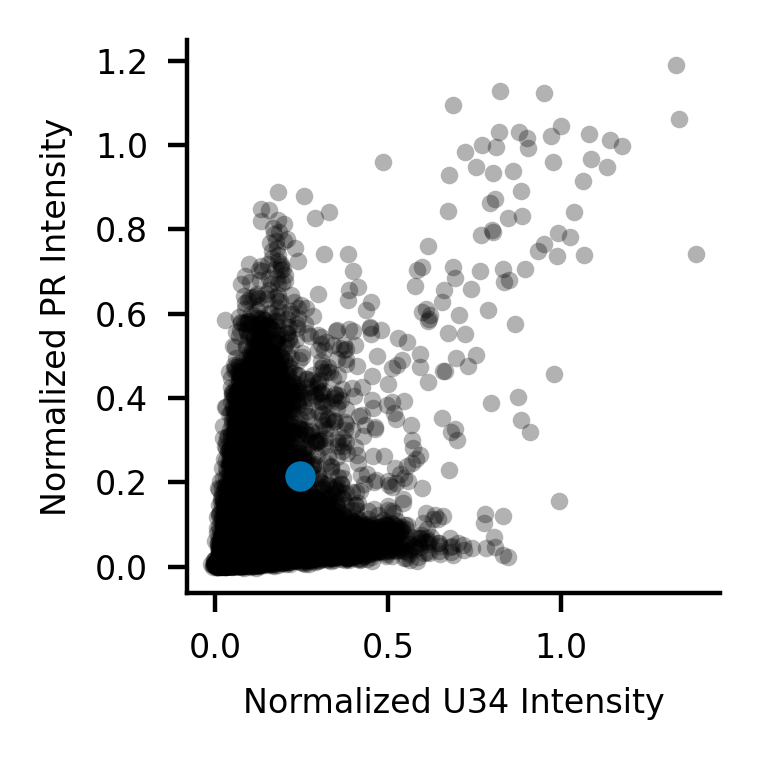

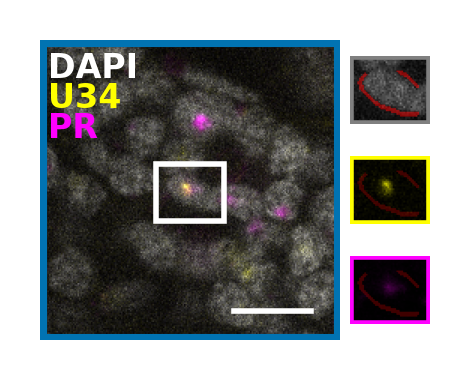

In [617]:
# u34-b3-488 lnc4-b1-546 u21-b5-647
plot_2_channels(results=results, image=image_data, metadata=metadata, 
                all_rois=all_rois, cell_borders=cell_borders, input=input, file=image, 
                c1=channels[0]+"-nucleus-sum", c2=channels[1]+"-nucleus-sum", 
                c1_name=channel_names[0], c2_name=channel_names[1],
                c1_color=channel_colors[0], c2_color=channel_colors[1],
                coordinates=[[nuc_thresholds[0], nuc_thresholds[1]]],
                dapi_max=255, c1_max=255, c2_max=255)

In [163]:
channels = ['AF488', 'AF546', 'AF647']
channel_names = ["U34", "PR", "U21"]
channel_colors = ["yellow", "magenta", "cyan"]
cyto_thresholds = [10_000, 5000, 5_000]
nuc_thresholds =  [20_000, 5000, 10_000]
channel_maxs = [255, 255, 255]

In [164]:
# Aggregate all the cells above the threshold for each cytoplasmic channel 
cytoplasmic_channels = results[results['cytoplasmic'].notnull()]['cytoplasmic'].unique()
for cytoplasmic_channel in cytoplasmic_channels: 
    cyto_threshold = cyto_thresholds[channels.index(cytoplasmic_channel)]
    nuc_threshold = nuc_thresholds[channels.index(cytoplasmic_channel)]
    results[f"{cytoplasmic_channel}-iscyto"] = (results[f"{cytoplasmic_channel}-cyto-sum"].values > cyto_threshold) & (results[f"{cytoplasmic_channel}-nucleus-sum"] > nuc_threshold)

In [165]:
# Calculate proportions of cells above the thresholds
all_cell_results = pd.DataFrame() 
for cytoplasmic_channel in cytoplasmic_channels: 
    results_cyto = results[results[f"{cytoplasmic_channel}-iscyto"]]
    results_grouped = results_cyto.groupby(['image']).size().reset_index(name='num_cells')
    for i, image in enumerate(results_grouped['image'].unique()):
        results_cyto_subset = results_cyto[results_cyto['image'] == image]
        for j, channel in enumerate(channels):
            results_grouped.at[i, f'{channel}-cyto'] = sum(results_cyto_subset[f'{channel}-cyto-sum'] > cyto_thresholds[j]) #/ results_grouped['num_cells'].values[i]
            results_grouped.at[i, f'{channel}-nucleus'] = sum(results_cyto_subset[f'{channel}-nucleus-sum'] > nuc_thresholds[j]) #/ results_grouped['num_cells'].values[i]
    results_grouped['cytoplasmic'] = cytoplasmic_channel
    all_cell_results = pd.concat([all_cell_results, results_grouped], ignore_index=True)
all_cell_results

image  num_cells  AF488-cyto  \
0  20250325 4 t19 lncrna sample 1 great.czi         50         0.0   
1  20250325 4 t19 lncrna sample 2 great.czi         42         1.0   
2  20250325 4 t19 lncrna sample 3 great.czi         78         2.0   
3  20250325 4 t19 lncrna sample 4 great.czi         98         0.0   
4  20250325 4 t19 lncrna sample 1 great.czi          5         5.0   
5  20250325 4 t19 lncrna sample 2 great.czi          2         2.0   
6  20250325 4 t19 lncrna sample 3 great.czi         40        40.0   
7  20250325 4 t19 lncrna sample 4 great.czi         35        35.0   

   AF488-nucleus  AF546-cyto  AF546-nucleus  AF647-cyto  AF647-nucleus  \
0            6.0         0.0           10.0        50.0           50.0   
1            6.0         0.0           10.0        42.0           42.0   
2           18.0         0.0           23.0        78.0           78.0   
3           34.0         1.0           28.0        98.0           98.0   
4            5.0         0.0            5.0         0.0            1.0   
5            2.0         0.0            2.0         1.0            1.0   
6           40.0         3.0           21.0         2.0            4.0   
7           35.0         2.0           24.0         1.0            0.0   

  cytoplasmic  
0       AF647  
1       AF647  
2       AF647  
3       AF647  
4       AF488  
5       AF488  
6       AF488  
7       AF488

In [166]:
# Melt results_thresholded, grouping by image and cytoplasmic, for cytoplasm
results_melted_cyto = all_cell_results.melt(id_vars=['image', 'cytoplasmic'],
                                               value_vars=[c+"-cyto" for c in channels],
                                               var_name='channel', 
                                               value_name='cyto_proportion')
results_melted_cyto['channel'] = results_melted_cyto['channel'].str.replace('-cyto', '')

# Melt results_thresholded, grouping by image and cytoplasmic, for nucleus
results_melted_nucleus = all_cell_results.melt(id_vars=['image', 'cytoplasmic'],
                                               value_vars=[c+"-nucleus" for c in channels],
                                               var_name='channel', 
                                               value_name='nucleus_proportion')
results_melted_nucleus['channel'] = results_melted_nucleus['channel'].str.replace('-nucleus', '')

# Combine the two melted dataframes
results_melted = pd.merge(results_melted_cyto, results_melted_nucleus, on=['image', 'cytoplasmic', 'channel'])
results_melted['channel_name'] = results_melted['channel'].map(dict(zip(channels, channel_names)))
results_melted['cytoplasmic_name'] = results_melted['cytoplasmic'].map(dict(zip(channels, channel_names)))
results_melted['cytoplasmic_name'] = results_melted['cytoplasmic_name'] + " cytoplasmic"
results_melted['num_cells'] = results_melted.apply(lambda x: 
                                                    all_cell_results[(all_cell_results['image'] == x['image']) & 
                                                    (all_cell_results['cytoplasmic'] == x['cytoplasmic'])]['num_cells'].values[0], axis=1)
results_melted.head()

image cytoplasmic channel  \
0  20250325 4 t19 lncrna sample 1 great.czi       AF647   AF488   
1  20250325 4 t19 lncrna sample 2 great.czi       AF647   AF488   
2  20250325 4 t19 lncrna sample 3 great.czi       AF647   AF488   
3  20250325 4 t19 lncrna sample 4 great.czi       AF647   AF488   
4  20250325 4 t19 lncrna sample 1 great.czi       AF488   AF488   

   cyto_proportion  nucleus_proportion channel_name cytoplasmic_name  \
0              0.0                 6.0          U34  U21 cytoplasmic   
1              1.0                 6.0          U34  U21 cytoplasmic   
2              2.0                18.0          U34  U21 cytoplasmic   
3              0.0                34.0          U34  U21 cytoplasmic   
4              5.0                 5.0          U34  U34 cytoplasmic   

   num_cells  
0         50  
1         42  
2         78  
3         98  
4          5

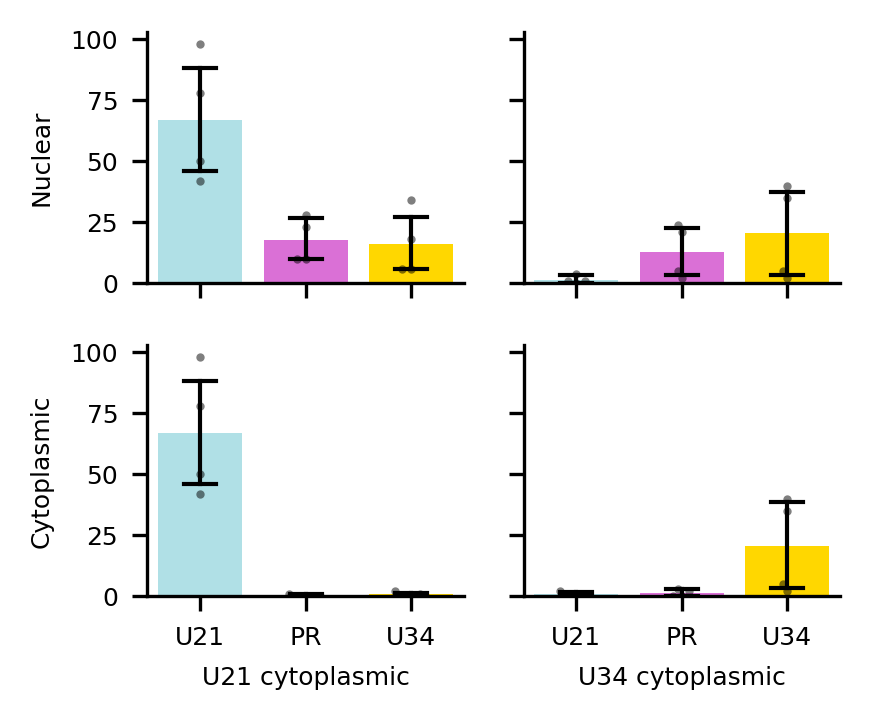

In [167]:
cytoplasmic_channels = ["U21 cytoplasmic", "U34 cytoplasmic"]
f, axs = plt.subplots(2, 2, figsize=(3, 2.5), dpi = 300, sharex=True, sharey=True)
for i, cytoplasmic_channel in enumerate(cytoplasmic_channels):
    results_channel = results_melted[results_melted["cytoplasmic_name"] == cytoplasmic_channel]
    ax = axs[0, i]
    sns.barplot(data=results_channel, x="channel_name", y="nucleus_proportion", ax=ax, palette=['powderblue', 'orchid', 'gold'], order=["U21", "PR", "U34"], saturation=1, 
                alpha=1, lw=0, errorbar=("ci", 95), capsize=0.3, errwidth=1, errcolor='black')
    sns.swarmplot(data=results_channel, x="channel_name", y="nucleus_proportion", ax=ax, color='black', alpha=0.5, s=2, legend=False, dodge=True)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlabel(f"{cytoplasmic_channel}", fontsize=6)
    ax.set_ylabel("Nuclear", fontsize=6)
    ax.tick_params(axis='both', which='major', labelsize=6)

    ax = axs[1, i]
    sns.barplot(data=results_channel, x="channel_name", y="cyto_proportion", ax=ax, palette=['powderblue', 'orchid', 'gold'], order=["U21", "PR", "U34"], saturation=1, 
                alpha=1, lw=0, errorbar=("ci", 95), capsize=0.3, errwidth=1, errcolor='black')
    sns.swarmplot(data=results_channel, x="channel_name", y="cyto_proportion", ax=ax, color='black', alpha=0.5, s=2, legend=False, dodge=True)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlabel(f"{cytoplasmic_channel}", fontsize=6)
    ax.set_ylabel("Cytoplasmic", fontsize=6)
    ax.tick_params(axis='both', which='major', labelsize=6)

plt.tight_layout()

## Figure 2

In [5]:
input = 'Q1'
input = [d for d in raw_data_dirs if input in d][0]
print(f'Using {input} as input directory')
# Load the results 
results_dir = f'../results/{input}'
results_path = os.path.join(results_dir, 'all_results_nuclei_cytoplasm_markers.csv')
results = pd.read_csv(results_path)

Using 20250328 2 P14 R2-b3-488 Q1-b1-546 Lnc6-b2-647 DAPI as input directory


In [37]:
channels = ['AF488', 'AF546', 'AF647']
channel_names = ['R2-3', 'Q1', 'PR']
channel_colors = ["yellow", "magenta", "cyan"]
cyto_thresholds = [0.4, 0.4, 0.3]
nuc_thresholds =  [0.4, 0.4, 0.25]
channel_maxs = [255, 255, 255]

In [63]:
# Calculate the percentage of the total signal intensity thats cytoplasmic vs nuclear 
for channel in channels: 
    results[f'{channel}-cyto-prop'] = results[f'{channel}-cyto-sum']  #/ (results[f'{channel}-nucleus-sum'] + results[f'{channel}-cyto-sum'])
    results[f'{channel}-total-sum'] = results[f'{channel}-cyto-sum'] + results[f'{channel}-nucleus-sum']
    
# Get only the cytoplasmic results
results_cytoplasmic = results[results['cytoplasmic'].notnull()]


# Melt results_thresholded, grouping by image and cytoplasmic, for cytoplasm
results_melted_cyto = results_cytoplasmic.melt(id_vars=['image', 'z', 'z_id', 'cytoplasmic'],
                                               value_vars=[c+"-cyto-prop" for c in channels],
                                               var_name='channel', 
                                               value_name='cyto-prop')
results_melted_cyto['channel'] = results_melted_cyto['channel'].str.replace('-cyto-prop', '')


# Melt results_thresholded, grouping by image and cytoplasmic, for nucleus
results_melted_nucleus = results_cytoplasmic.melt(id_vars=['image', 'z', 'z_id', 'cytoplasmic'],
                                               value_vars=[c+"-total-sum" for c in channels],
                                               var_name='channel', 
                                               value_name='total-sum')
results_melted_nucleus['channel'] = results_melted_nucleus['channel'].str.replace('-total-sum', '')

# Combine the two melted dataframes
results_melted = pd.merge(results_melted_cyto, results_melted_nucleus, on=['image', 'z', 'z_id', 'cytoplasmic', 'channel'])
results_melted['channel_name'] = results_melted['channel'].map(dict(zip(channels, channel_names)))
results_melted['cytoplasmic_name'] = results_melted['cytoplasmic'].map(dict(zip(channels, channel_names)))
results_melted['cytoplasmic_name'] = results_melted['cytoplasmic_name'] + " cytoplasmic"
results_melted

image   z  z_id cytoplasmic channel  cyto-prop  \
0     20250328 2 Q1lnc sample 2.czi  17   175       AF546   AF488       2815   
1     20250328 2 Q1lnc sample 2.czi  18   158       AF546   AF488       3513   
2     20250328 2 Q1lnc sample 2.czi  20   184       AF488   AF488       5215   
3     20250328 2 Q1lnc sample 2.czi  20   317       AF488   AF488       3512   
4     20250328 2 Q1lnc sample 2.czi  21    58       AF546   AF488       2919   
...                             ...  ..   ...         ...     ...        ...   
1108  20250328 2 Q1lnc sample 4.czi  86    47       AF546   AF647       2379   
1109  20250328 2 Q1lnc sample 4.czi  86   262       AF488   AF647       4448   
1110  20250328 2 Q1lnc sample 4.czi  89    39       AF488   AF647       3371   
1111  20250328 2 Q1lnc sample 4.czi  89    65       AF488   AF647       6171   
1112  20250328 2 Q1lnc sample 4.czi  93    71       AF488   AF647       5715   

      total-sum channel_name  cytoplasmic_name  
0         26455         R2-3    Q1 cytoplasmic  
1         31657         R2-3    Q1 cytoplasmic  
2         36452         R2-3  R2-3 cytoplasmic  
3         51233         R2-3  R2-3 cytoplasmic  
4         25941         R2-3    Q1 cytoplasmic  
...         ...          ...               ...  
1108      11013           PR    Q1 cytoplasmic  
1109      64854           PR  R2-3 cytoplasmic  
1110      10556           PR  R2-3 cytoplasmic  
1111      64257           PR  R2-3 cytoplasmic  
1112      60181           PR  R2-3 cytoplasmic  

[1113 rows x 9 columns]

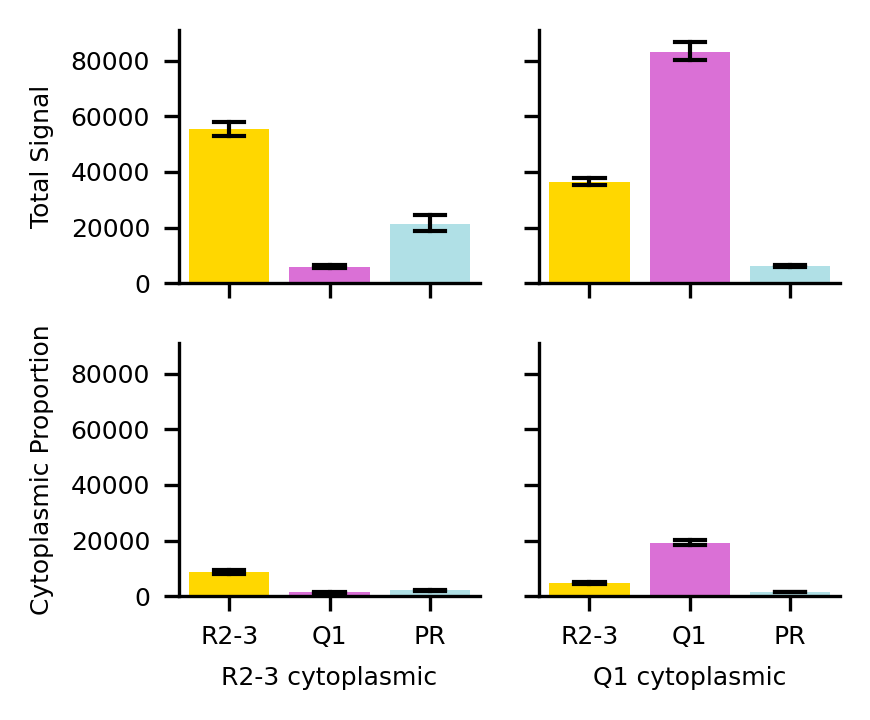

In [64]:
cytoplasmic_channels = ["R2-3 cytoplasmic", "Q1 cytoplasmic"]
f, axs = plt.subplots(2, 2, figsize=(3, 2.5), dpi = 300, sharex=True, sharey=True)
for i, cytoplasmic_channel in enumerate(cytoplasmic_channels):
    results_channel = results_melted[results_melted["cytoplasmic_name"] == cytoplasmic_channel]
    ax = axs[0, i]
    sns.barplot(data=results_channel, x="channel_name", y="total-sum", ax=ax, palette=['gold', 'orchid', 'powderblue'], order=["R2-3", "Q1", "PR"], saturation=1, 
                alpha=1, lw=0, errorbar=("ci", 95), capsize=0.3, errwidth=1, errcolor='black')
    #sns.swarmplot(data=results_channel, x="channel_name", y="total-sum", ax=ax, color='black', alpha=0.5, s=2, legend=False, dodge=True)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlabel(f"{cytoplasmic_channel}", fontsize=6)
    ax.set_ylabel("Total Signal", fontsize=6)
    ax.tick_params(axis='both', which='major', labelsize=6)

    ax = axs[1, i]
    sns.barplot(data=results_channel, x="channel_name", y="cyto-prop", ax=ax, palette=['gold', 'orchid', 'powderblue'], order=["R2-3", "Q1", "PR"], saturation=1, 
                alpha=1, lw=0, errorbar=("ci", 95), capsize=0.3, errwidth=1, errcolor='black')
    #sns.swarmplot(data=results_channel, x="channel_name", y="cyto-prop", ax=ax, color='black', alpha=0.5, s=2, legend=False, dodge=True)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlabel(f"{cytoplasmic_channel}", fontsize=6)
    ax.set_ylabel("Cytoplasmic Proportion", fontsize=6)
    ax.tick_params(axis='both', which='major', labelsize=6)

plt.tight_layout()

In [40]:
"""quantile = 0.000001 
channels_to_normalize = [c + "-nucleus-sum" for c in channels] + [c + "-cyto-sum" for c in channels]
for sample in results['image'].unique():
        results_sample = results[results['image'] == sample]
        for channel in channels_to_normalize: 
            lower = results_sample[channel].quantile(quantile)
            upper = results_sample[channel].quantile(1-quantile)
            results_sample[channel] = (results_sample[channel] - lower) / (upper - lower)
        results.loc[results['image'] == sample] = results_sample"""

'quantile = 0.000001 \nchannels_to_normalize = [c + "-nucleus-sum" for c in channels] + [c + "-cyto-sum" for c in channels]\nfor sample in results[\'image\'].unique():\n        results_sample = results[results[\'image\'] == sample]\n        for channel in channels_to_normalize: \n            lower = results_sample[channel].quantile(quantile)\n            upper = results_sample[channel].quantile(1-quantile)\n            results_sample[channel] = (results_sample[channel] - lower) / (upper - lower)\n        results.loc[results[\'image\'] == sample] = results_sample'

In [41]:
file_number = 0 
results_files = os.listdir(f'../raw-data/{input}')
image = results_files[file_number].replace(".csv", ".czi")
image_path = f'../raw-data/{input}/{image}'
reader = napari_get_reader(image_path)
if reader is not None:
    layer_data = reader(image_path)
    image_data, metadata, layer_type = layer_data[0]
    print(f"Loaded {image_path}")
    print("Metadata:", metadata)
    print("Image shape:", image_data.shape)  

# Load ROIs 
all_rois_path = f'../results/{input}/{image.replace(".czi", "_rois.npy")}'
all_rois = np.load(all_rois_path)
print(f"Loaded {all_rois_path}")

# Load cell_borders 
cell_borders_path = f'../results/{input}/{image.replace(".czi", "_cell_borders.npy")}'
cell_borders = np.load(cell_borders_path)
print(f"Loaded {cell_borders_path}")

Loaded ../raw-data/20250328 2 P14 R2-b3-488 Q1-b1-546 Lnc6-b2-647 DAPI/20250328 2 Q1lnc sample 6.czi
Metadata: {'rgb': False, 'channel_axis': 2, 'translate': (0.0, 0.0, 0.0, 0.0), 'scale': (1.0, 1.0, 0.0974884033203125, 0.0974884033203125), 'contrast_limits': None, 'name': ['AF546-T1', 'AF488-T2', 'DAPI-T3', 'AF647-T3']}
Image shape: (1, 103, 4, 2048, 2048)
Loaded ../results/20250328 2 P14 R2-b3-488 Q1-b1-546 Lnc6-b2-647 DAPI/20250328 2 Q1lnc sample 6_rois.npy
Loaded ../results/20250328 2 P14 R2-b3-488 Q1-b1-546 Lnc6-b2-647 DAPI/20250328 2 Q1lnc sample 6_cell_borders.npy


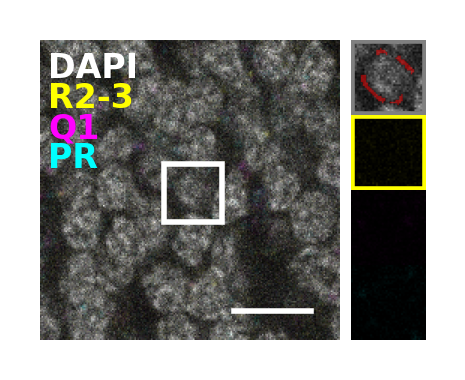

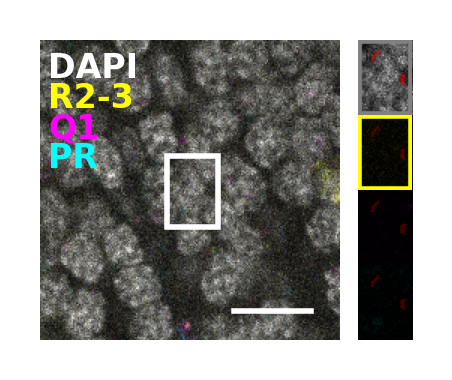

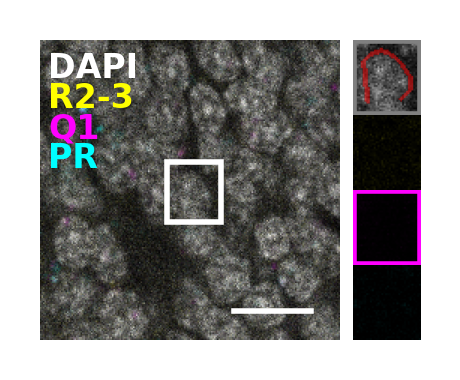

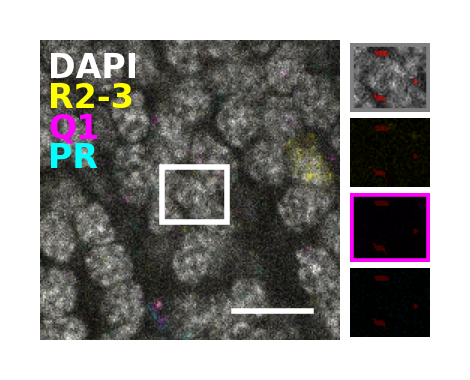

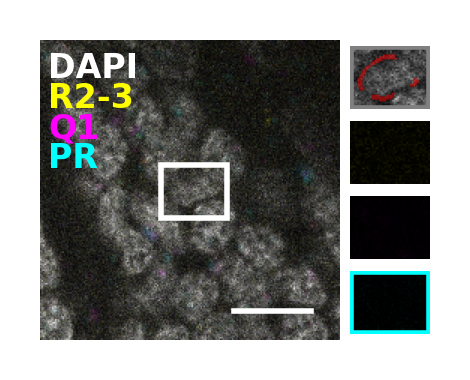

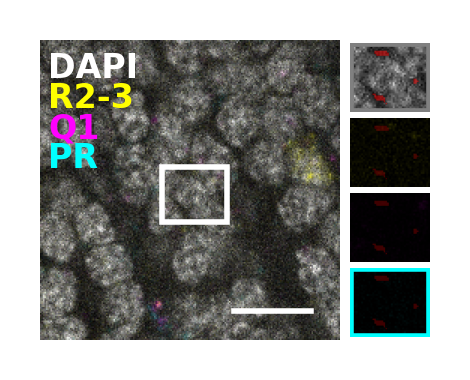

In [42]:
plot_thresholds(results, nuc_thresholds, cyto_thresholds,
                channels, channel_names, channel_colors, channel_maxs, 
                image_data, metadata, all_rois, cell_borders, image, 
                pixel_bounds=100, bbox_expansion=7) 

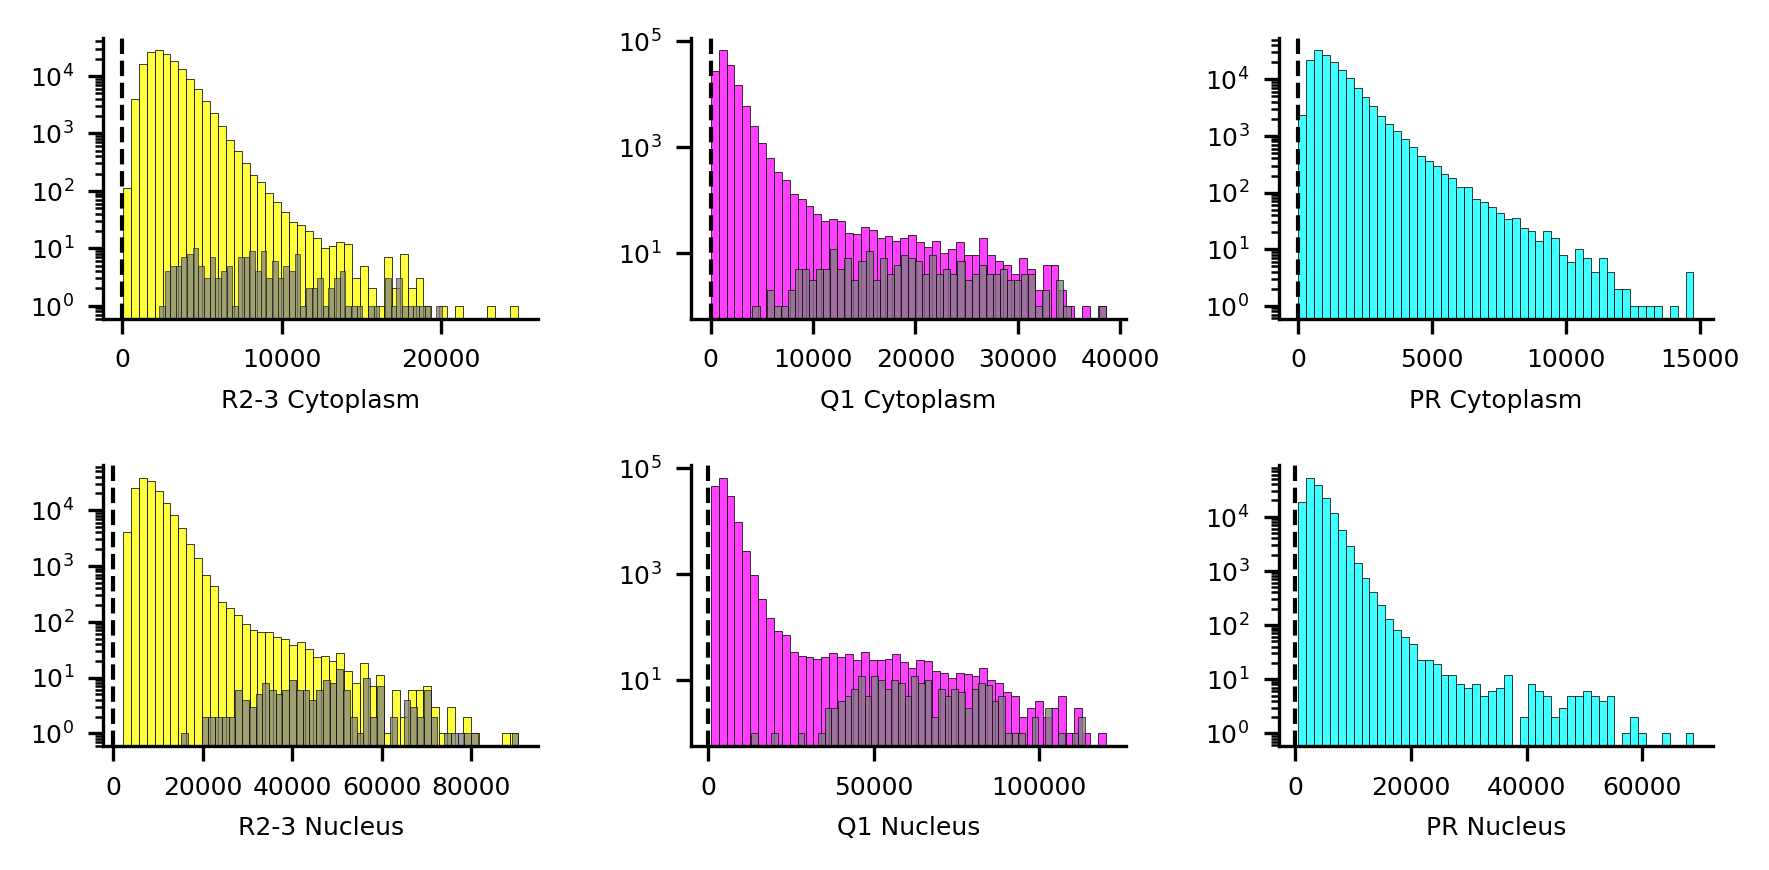

In [44]:
# Plot histograms of -cyto-sum and -nucleus-sum for all channels 
f, ax = plt.subplots(2, len(channels), figsize=(2*len(channels), 3), dpi=300)
for i, channel in enumerate(channels): 
    # Plot -cyto-sum
    sns.histplot(data=results, x=f'{channel}-cyto-sum', ax=ax[0][i], color=channel_colors[i], bins=50)
    if channel in results['cytoplasmic'].unique(): 
        sns.histplot(data=results[results['cytoplasmic'] == channel], x=f'{channel}-cyto-sum', ax=ax[0][i], color='grey', bins=50)
    ax[0][i].set_yscale('log')
    ax[0][i].set_xlabel(f'{channel_names[i]} Cytoplasm', fontsize=6)
    ax[0][i].tick_params(axis='both', which='major', labelsize=6)
    ax[0][i].set_ylabel('')
    ax[0][i].spines['top'].set_visible(False)
    ax[0][i].spines['right'].set_visible(False)
    ax[0][i].axvline(cyto_thresholds[i], color='black', linestyle='--', lw=1)

    # Plot -nucleus-sum
    sns.histplot(data=results, x=f'{channel}-nucleus-sum', ax=ax[1][i], color=channel_colors[i], bins=50)
    if channel in results['cytoplasmic'].unique(): 
        sns.histplot(data=results[results['cytoplasmic'] == channel], x=f'{channel}-nucleus-sum', ax=ax[1][i], color='grey', bins=50)
    ax[1][i].set_yscale('log')
    ax[1][i].set_xlabel(f'{channel_names[i]} Nucleus', fontsize=6)
    ax[1][i].tick_params(axis='both', which='major', labelsize=6)
    ax[1][i].set_ylabel('')
    ax[1][i].spines['top'].set_visible(False)
    ax[1][i].spines['right'].set_visible(False)
    ax[1][i].axvline(nuc_thresholds[i], color='black', linestyle='--', lw=1)

plt.tight_layout()
plt.show()

In [54]:
channels = ['AF488', 'AF546', 'AF647']
channel_names = ['R2-3', 'Q1', 'PR']
channel_colors = ["yellow", "magenta", "cyan"]
cyto_thresholds = [8000, 10000, 5000]
nuc_thresholds =  [20000, 30000, 20000]
channel_maxs = [255, 255, 255]

In [55]:
# Calculate proportions of cells above the thresholds
results_thresholded = results.groupby(['image', 'cytoplasmic']).size().reset_index(name='num_cells')
for i, row in results_thresholded.iterrows():
    results_subset = results[(results['image'] == row['image']) & (results['cytoplasmic'] == row['cytoplasmic'])]
    for j, channel in enumerate(channels):
        results_thresholded.at[i, f'{channel}-cyto'] = sum(results_subset[f'{channel}-cyto-sum'] > cyto_thresholds[j]) / row['num_cells']
        results_thresholded.at[i, f'{channel}-nucleus'] = sum(results_subset[f'{channel}-nucleus-sum'] > nuc_thresholds[j]) / row['num_cells']

# Melt results_thresholded, grouping by image and cytoplasmic, for cytoplasm
results_melted_cyto = results_thresholded.melt(id_vars=['image', 'cytoplasmic'],
                                               value_vars=[c+"-cyto" for c in channels],
                                               var_name='channel', 
                                               value_name='cyto_proportion')
results_melted_cyto['channel'] = results_melted_cyto['channel'].str.replace('-cyto', '')

# Melt results_thresholded, grouping by image and cytoplasmic, for nucleus
results_melted_nucleus = results_thresholded.melt(id_vars=['image', 'cytoplasmic'],
                                               value_vars=[c+"-nucleus" for c in channels],
                                               var_name='channel', 
                                               value_name='nucleus_proportion')
results_melted_nucleus['channel'] = results_melted_nucleus['channel'].str.replace('-nucleus', '')

# Combine the two melted dataframes
results_melted = pd.merge(results_melted_cyto, results_melted_nucleus, on=['image', 'cytoplasmic', 'channel'])
results_melted['channel_name'] = results_melted['channel'].map(dict(zip(channels, channel_names)))
results_melted['cytoplasmic_name'] = results_melted['cytoplasmic'].map(dict(zip(channels, channel_names)))
results_melted['cytoplasmic_name'] = results_melted['cytoplasmic_name'] + " cytoplasmic"
results_melted['num_cells'] = results_melted.apply(lambda x: 
                                                    results_thresholded[(results_thresholded['image'] == x['image']) & 
                                                    (results_thresholded['cytoplasmic'] == x['cytoplasmic'])]['num_cells'].values[0], axis=1)
results_melted.head()

image cytoplasmic channel  cyto_proportion  \
0  20250328 2 Q1lnc sample 1.czi       AF488   AF488         0.600000   
1  20250328 2 Q1lnc sample 1.czi       AF546   AF488         0.029412   
2  20250328 2 Q1lnc sample 2.czi       AF488   AF488         0.304348   
3  20250328 2 Q1lnc sample 2.czi       AF546   AF488         0.000000   
4  20250328 2 Q1lnc sample 3.czi       AF488   AF488         0.457143   

   nucleus_proportion channel_name  cytoplasmic_name  num_cells  
0            1.000000         R2-3  R2-3 cytoplasmic         25  
1            0.941176         R2-3    Q1 cytoplasmic         34  
2            1.000000         R2-3  R2-3 cytoplasmic         23  
3            0.918919         R2-3    Q1 cytoplasmic         37  
4            1.000000         R2-3  R2-3 cytoplasmic         35

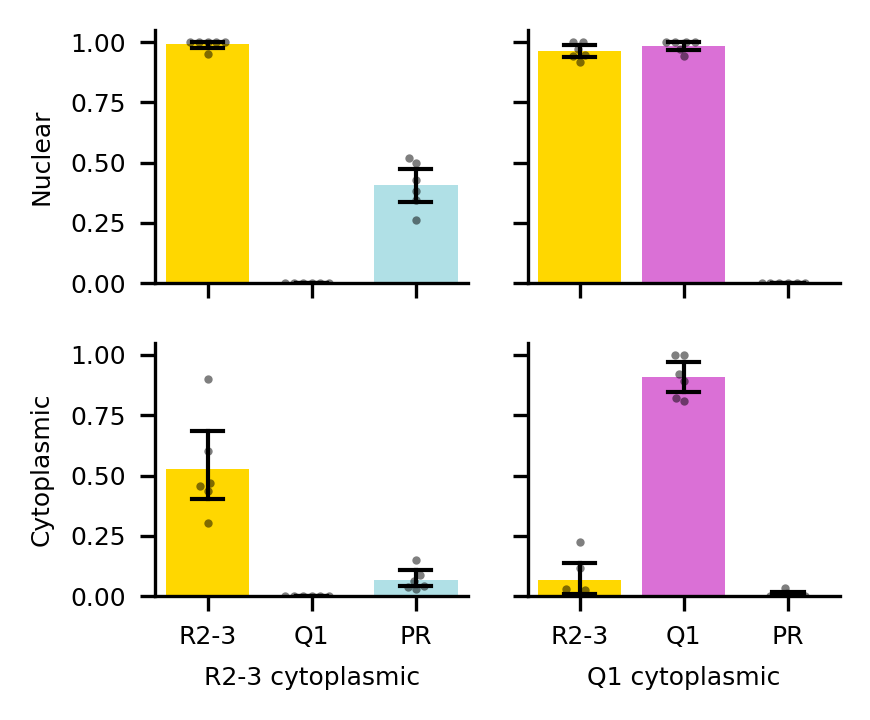

In [56]:
cytoplasmic_channels = ["R2-3 cytoplasmic", "Q1 cytoplasmic"]
f, axs = plt.subplots(2, 2, figsize=(3, 2.5), dpi = 300, sharex=True, sharey=True)
for i, cytoplasmic_channel in enumerate(cytoplasmic_channels):
    results_channel = results_melted[results_melted["cytoplasmic_name"] == cytoplasmic_channel]
    ax = axs[0, i]
    sns.barplot(data=results_channel, x="channel_name", y="nucleus_proportion", ax=ax, palette=['gold', 'orchid', 'powderblue'], order=["R2-3", "Q1", "PR"], saturation=1, 
                alpha=1, lw=0, errorbar=("ci", 95), capsize=0.3, errwidth=1, errcolor='black')
    sns.swarmplot(data=results_channel, x="channel_name", y="nucleus_proportion", ax=ax, color='black', alpha=0.5, s=2, legend=False, dodge=True)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlabel(f"{cytoplasmic_channel}", fontsize=6)
    ax.set_ylabel("Nuclear", fontsize=6)
    ax.tick_params(axis='both', which='major', labelsize=6)

    ax = axs[1, i]
    sns.barplot(data=results_channel, x="channel_name", y="cyto_proportion", ax=ax, palette=['gold', 'orchid', 'powderblue'], order=["R2-3", "Q1", "PR"], saturation=1, 
                alpha=1, lw=0, errorbar=("ci", 95), capsize=0.3, errwidth=1, errcolor='black')
    sns.swarmplot(data=results_channel, x="channel_name", y="cyto_proportion", ax=ax, color='black', alpha=0.5, s=2, legend=False, dodge=True)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlabel(f"{cytoplasmic_channel}", fontsize=6)
    ax.set_ylabel("Cytoplasmic", fontsize=6)
    ax.tick_params(axis='both', which='major', labelsize=6)

plt.tight_layout()

In [57]:
# Aggregate all the cells above the threshold for each cytoplasmic channel 
cytoplasmic_channels = results[results['cytoplasmic'].notnull()]['cytoplasmic'].unique()
for cytoplasmic_channel in cytoplasmic_channels: 
    cyto_threshold = cyto_thresholds[channels.index(cytoplasmic_channel)]
    nuc_threshold = nuc_thresholds[channels.index(cytoplasmic_channel)]
    results[f"{cytoplasmic_channel}-iscyto"] = (results[f"{cytoplasmic_channel}-cyto-sum"].values > cyto_threshold) & (results[f"{cytoplasmic_channel}-nucleus-sum"] > nuc_threshold)

In [58]:
# Calculate proportions of cells above the thresholds
all_cell_results = pd.DataFrame() 
for cytoplasmic_channel in cytoplasmic_channels: 
    results_cyto = results[results[f"{cytoplasmic_channel}-iscyto"]]
    results_grouped = results_cyto.groupby(['image']).size().reset_index(name='num_cells')
    for i, image in enumerate(results_grouped['image'].unique()):
        results_cyto_subset = results_cyto[results_cyto['image'] == image]
        for j, channel in enumerate(channels):
            results_grouped.at[i, f'{channel}-cyto'] = sum(results_cyto_subset[f'{channel}-cyto-sum'] > cyto_thresholds[j]) / results_grouped['num_cells'].values[i]
            results_grouped.at[i, f'{channel}-nucleus'] = sum(results_cyto_subset[f'{channel}-nucleus-sum'] > nuc_thresholds[j]) / results_grouped['num_cells'].values[i]
    results_grouped['cytoplasmic'] = cytoplasmic_channel
    all_cell_results = pd.concat([all_cell_results, results_grouped], ignore_index=True)
all_cell_results

image  num_cells  AF488-cyto  AF488-nucleus  \
0   20250328 2 Q1lnc sample 1.czi         68    0.029412       0.838235   
1   20250328 2 Q1lnc sample 2.czi         76    0.000000       0.750000   
2   20250328 2 Q1lnc sample 3.czi         90    0.011111       0.744444   
3   20250328 2 Q1lnc sample 4.czi         67    0.044776       0.835821   
4   20250328 2 Q1lnc sample 5.czi        102    0.264706       0.852941   
5   20250328 2 Q1lnc sample 6.czi         86    0.081395       0.813953   
6   20250328 2 Q1lnc sample 1.czi         53    1.000000       1.000000   
7   20250328 2 Q1lnc sample 2.czi         17    1.000000       1.000000   
8   20250328 2 Q1lnc sample 3.czi         45    1.000000       1.000000   
9   20250328 2 Q1lnc sample 4.czi        151    1.000000       1.000000   
10  20250328 2 Q1lnc sample 5.czi        266    1.000000       1.000000   
11  20250328 2 Q1lnc sample 6.czi         52    1.000000       1.000000   

    AF546-cyto  AF546-nucleus  AF647-cyto  AF647-nucleus cytoplasmic  
0     1.000000       1.000000    0.000000       0.000000       AF546  
1     1.000000       1.000000    0.000000       0.000000       AF546  
2     1.000000       1.000000    0.000000       0.000000       AF546  
3     1.000000       1.000000    0.029851       0.000000       AF546  
4     1.000000       1.000000    0.078431       0.029412       AF546  
5     1.000000       1.000000    0.000000       0.000000       AF546  
6     0.037736       0.037736    0.169811       0.301887       AF488  
7     0.000000       0.000000    0.117647       0.470588       AF488  
8     0.022222       0.022222    0.155556       0.577778       AF488  
9     0.039735       0.019868    0.311258       0.145695       AF488  
10    0.124060       0.093985    0.364662       0.157895       AF488  
11    0.134615       0.134615    0.096154       0.365385       AF488

In [59]:
# Melt results_thresholded, grouping by image and cytoplasmic, for cytoplasm
results_melted_cyto = all_cell_results.melt(id_vars=['image', 'cytoplasmic'],
                                               value_vars=[c+"-cyto" for c in channels],
                                               var_name='channel', 
                                               value_name='cyto_proportion')
results_melted_cyto['channel'] = results_melted_cyto['channel'].str.replace('-cyto', '')

# Melt results_thresholded, grouping by image and cytoplasmic, for nucleus
results_melted_nucleus = all_cell_results.melt(id_vars=['image', 'cytoplasmic'],
                                               value_vars=[c+"-nucleus" for c in channels],
                                               var_name='channel', 
                                               value_name='nucleus_proportion')
results_melted_nucleus['channel'] = results_melted_nucleus['channel'].str.replace('-nucleus', '')

# Combine the two melted dataframes
results_melted = pd.merge(results_melted_cyto, results_melted_nucleus, on=['image', 'cytoplasmic', 'channel'])
results_melted['channel_name'] = results_melted['channel'].map(dict(zip(channels, channel_names)))
results_melted['cytoplasmic_name'] = results_melted['cytoplasmic'].map(dict(zip(channels, channel_names)))
results_melted['cytoplasmic_name'] = results_melted['cytoplasmic_name'] + " cytoplasmic"
results_melted['num_cells'] = results_melted.apply(lambda x: 
                                                    all_cell_results[(all_cell_results['image'] == x['image']) & 
                                                    (all_cell_results['cytoplasmic'] == x['cytoplasmic'])]['num_cells'].values[0], axis=1)
results_melted.head()

image cytoplasmic channel  cyto_proportion  \
0  20250328 2 Q1lnc sample 1.czi       AF546   AF488         0.029412   
1  20250328 2 Q1lnc sample 2.czi       AF546   AF488         0.000000   
2  20250328 2 Q1lnc sample 3.czi       AF546   AF488         0.011111   
3  20250328 2 Q1lnc sample 4.czi       AF546   AF488         0.044776   
4  20250328 2 Q1lnc sample 5.czi       AF546   AF488         0.264706   

   nucleus_proportion channel_name cytoplasmic_name  num_cells  
0            0.838235         R2-3   Q1 cytoplasmic         68  
1            0.750000         R2-3   Q1 cytoplasmic         76  
2            0.744444         R2-3   Q1 cytoplasmic         90  
3            0.835821         R2-3   Q1 cytoplasmic         67  
4            0.852941         R2-3   Q1 cytoplasmic        102

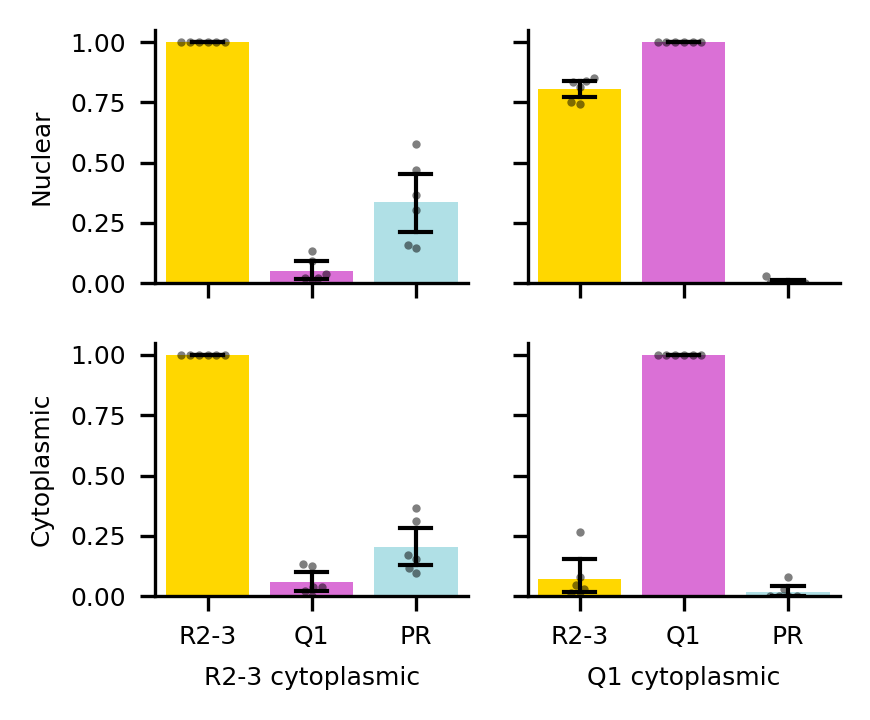

In [61]:
cytoplasmic_channels = ["R2-3 cytoplasmic", "Q1 cytoplasmic"]
f, axs = plt.subplots(2, 2, figsize=(3, 2.5), dpi = 300, sharex=True, sharey=True)
for i, cytoplasmic_channel in enumerate(cytoplasmic_channels):
    results_channel = results_melted[results_melted["cytoplasmic_name"] == cytoplasmic_channel]
    ax = axs[0, i]
    sns.barplot(data=results_channel, x="channel_name", y="nucleus_proportion", ax=ax, palette=['gold', 'orchid', 'powderblue'], order=["R2-3", "Q1", "PR"], saturation=1, 
                alpha=1, lw=0, errorbar=("ci", 95), capsize=0.3, errwidth=1, errcolor='black')
    sns.swarmplot(data=results_channel, x="channel_name", y="nucleus_proportion", ax=ax, color='black', alpha=0.5, s=2, legend=False, dodge=True)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlabel(f"{cytoplasmic_channel}", fontsize=6)
    ax.set_ylabel("Nuclear", fontsize=6)
    ax.tick_params(axis='both', which='major', labelsize=6)

    ax = axs[1, i]
    sns.barplot(data=results_channel, x="channel_name", y="cyto_proportion", ax=ax, palette=['gold', 'orchid', 'powderblue'], order=["R2-3", "Q1", "PR"], saturation=1, 
                alpha=1, lw=0, errorbar=("ci", 95), capsize=0.3, errwidth=1, errcolor='black')
    sns.swarmplot(data=results_channel, x="channel_name", y="cyto_proportion", ax=ax, color='black', alpha=0.5, s=2, legend=False, dodge=True)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlabel(f"{cytoplasmic_channel}", fontsize=6)
    ax.set_ylabel("Cytoplasmic", fontsize=6)
    ax.tick_params(axis='both', which='major', labelsize=6)

plt.tight_layout()